# Immediate Task: how can we automate the selection of the frequency?

In [11]:
from reservoir import *

# import packages
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sns

# import sub-packages
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.io import loadmat
%matplotlib inline
#reservoir.__file__
#%run -i '/Users/hayden/Desktop/DL_LAB/Reservoir/reservoir/esn.py'


# GOAL: The first step is to save the best_arguments results in some sort of easily accessed file. Also save the data: ie the predictions. We need a better file system with automatically changing variable names and nice file structure.

Additionally lets make the selection of different sizes of spectogram seamless.



# User Defined values:

In [12]:
file_ = "spectogram_data/"
size = "medium" #"medium"
freq = "2k"
spread = "small_spread"
obs = "small_obs"
file_ = file_ + size + "/"
file_

'spectogram_data/medium/'

#...

In [13]:


#size_options = { "small" : 512, "medium" : 1024, "publish": 3000}

spect_files  = { "publish" : "_new", "small" : "_512" , "original" : "", "medium" : "_1024"}

spect_xrange = {  "publish" : range(0,3400, 500), "small" : range(0, 512, 50)}

# TODO: Hard code values of frequencies

In [14]:
complex_dict = {
    "small" : { 
        
        #target_frequencies
        "2k" : 101,
        "4k" : 206,
        "8k" : 307,
        
        #target spread sizes
        "no_spread" : None,
        "small_spread" : 4,
        "medium_spread" : 12,
        "large_spread" : 24,
        
        #observer values
        "small_obs" : 10,
        "medium_obs" : 25,
        "large_obs" : 50
    },
    "medium" : { 
        
        #target_frequencies
        "2k" : 101,
        "4k" : 206,
        "8k" : 307,
        
        #target spread sizes
        "no_spread" : None,
        "small_spread" : 4,
        "medium_spread" : 12,
        "large_spread" : 24,
        
        #observer values
        "small_obs" : 10,
        "medium_obs" : 25,
        "large_obs" : 50
    },
    
    "publish": {
        "2k" : 546,
        "4k" : 1089,
        "8k" : 2177,
        "0.5_sec" : 1371,
        "0.7_sec" : 1924
    }
}

def spect_(request, size = size):
    """
    This function returns a hard-coded specogram size specific value.
    """
    hi = complex_dict[size]
    hi = hi[request]
    return(hi)
#spect_('2k')

# i. Load Data

['spectogram_data/medium/T_1024', 'spectogram_data/medium/f_1024', 'spectogram_data/medium/Intensity_1024']
successfully loaded ['spectogram_data/medium/T_1024', 'spectogram_data/medium/f_1024', 'spectogram_data/medium/Intensity_1024']
data loaded
maximum frequency: 11020
(1103, 1024)


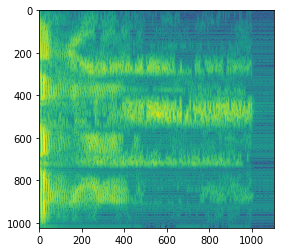

In [15]:
files2import = [file_  + i + spect_files[size] for i in ("T", "f", "Intensity") ]
print(files2import)
data_lst = []
for i in files2import:
    data_lst.append(loadmat(i))
print("successfully loaded " +str(files2import) ) 
T, f, A = data_lst

#preprocessing
T, A = T['T'], A['M']
T, A = np.transpose(T), (A - np.mean(A))/np.std(A)
A_orig = A.copy()
print("data loaded")
A_orig = np.rot90(A_orig, k = 1, axes = (0, 1))
plt.imshow(A_orig)

f = f['f'].reshape(-1,).tolist()
global max_freq; max_freq = int(np.max(f))
print("maximum frequency: " + str(max_freq))
freq_axis_len = A.shape[0]
time_axis_len = A.shape[1]
print(A.shape)

# Target Freq code, repeated above observers for sense, olab_display

In [16]:
def olab_display(axis, f = f, return_index = False):
    oA = np.rot90(A_orig.copy().copy(), k = 3, axes = (0, 1))
    #oA stands for other lab A
    oA = pd.DataFrame(oA).copy()
    f = [int(i) for i in f]
    freq_idx = f#[ int(i / 100) * 100 for i in f.tolist()]
    oA.index = freq_idx

    yticks = list( range( 0, max_freq, 1000))

    y_ticks = [ int(i) for i in yticks]

    my_heat = sns.heatmap(oA, center=0, cmap=sns.color_palette("CMRmap"), 
                          yticklabels = A.shape[0]//10, ax = axis)
    #, cmap = sns.color_palette("RdBu_r", 7))
    axis.set_ylabel('Frequency (Hz)')#,rotation=0)
    axis.set_xlabel('time')

    my_heat.invert_yaxis()
    plt.yticks(rotation=0)
    return(freq_idx)






# FIND KEY FREQUENCIES

## KEY FUNCTION: IDX2FREQ

In [17]:
def idx2Freq(val):
    idx = min(range(len(f)), key=lambda i: abs(f[i]-val))
    return(idx)
key_freq_idxs = {}
for i in (2000, 4000, 8000):
    height = freq_axis_len
    key_freq_idxs[i] = height - idx2Freq(i)

display(key_freq_idxs)

target_freq_ = { #"center" : complex_dict[size][freq] ,
                "spread" : 50 } #complex_dict[size][spread]}

{2000: 903, 4000: 703, 8000: 303}

# Display Data vertically with correct index

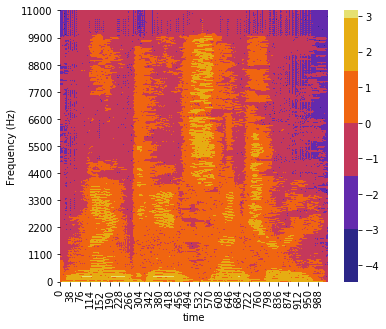

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (6,5))
freq_idx  = olab_display(ax)

# Horizontal display with proper index

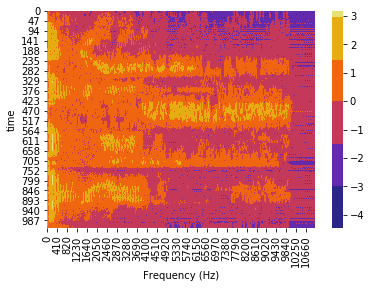

In [19]:
A_pd = pd.DataFrame(A_orig)

A_pd.columns = freq_idx
my_heat= sns.heatmap(A_pd,  center=0, cmap=sns.color_palette("CMRmap"))
plt.xlabel('Frequency (Hz)')
plt.ylabel('time')
A = A_pd.values

# Helper Functions

Consider eliminating validation set superfluous lines

### plot_timeseries and sub_helper function

In [20]:
def build_pd(np_, n_series):
    series_len = np_.shape[0]
    for i in range(n_series): 
        id_np =  np.zeros((series_len, 1)).reshape(-1, 1) + i
        series_spec = np_[:, i].reshape(-1, 1)
        t = np.array( list( range( series_len))).reshape(-1, 1)
        pd_spec = np.concatenate( [ t, series_spec, id_np], axis = 1)
        pd_spec = pd.DataFrame(pd_spec)
        pd_spec.columns = ["t", "x", "id"]
        if i == 0:
            df = pd_spec 
        else:
            df = pd.concat([df, pd_spec], axis = 0)
    return(df)



def plot_timeseries(prediction_, 
                    train, 
                    test, 
                    titl = "ESN ", 
                    series2plot = 0, 
                    method = None,
                    label_loc = (0., 0.)):
    """
    This function makes three plots:
        the prediction, the residual, the loss.
    It was built for single predictions, but needs to be upgraded to deal with multiple output.
    We need to show: average residual, average loss.
    """
    full_dat = np.concatenate([train, test], axis = 0); full_dat_avg = np.mean(full_dat, axis = 1)
    n_series, series_len = test.shape[1], test.shape[0]
    assert method in ["all", "single", "avg"], "Please choose a method: avg, all, or single"
    #assert method != "all", "Not yet implimented #TODO"
    
    if method == "single":
        label_loc = (0.02, 0.65)
    
    #key indexes
    trainlen, testlen, pred_shape = train.shape[0], test.shape[0], prediction_.shape[0]
    
    if method == "single":
        if n_series > 1:
            print("There are " + str(n_series) + " time series, you selected time series " 
                  + str(series2plot + 1))
        
        # avoid choosing all of the columns. subset by the selected time series.
        train, test, prediction = train[:, series2plot], test[:, series2plot], prediction_[:, series2plot]
        
        
        # set up dataframe
        xTrTarg_pd = pd.DataFrame(test)
        t = pd.DataFrame(list(range(len(xTrTarg_pd))))
        
        # append time
        Target_pd = pd.concat([xTrTarg_pd, t], axis = 1)
        Target_pd.columns = ["x", "t"]
        
         #calculate the residual
        resid = test.reshape(-1,)[:pred_shape] - prediction.reshape(-1,) #pred_shape[0]
        
        rmse_spec =  str(round(myMSE(prediction, test), 5))
        full_dat = np.concatenate([train, test], axis = 0)
        
    elif method == "avg":
        rmse_spec =  str(round(myMSE(prediction_, test), 5))
        prediction = prediction_.copy().copy()
        
        def collapse(array):
            return(np.mean(array, axis = 1))
        vals = []
        #y - yhat
        resid_np = test - prediction_
        
        for i in [train, test, prediction_, resid_np]:
            vals.append(collapse(i))
            
        train, test, prediction_avg, resid = vals
        #return(prediction)
    else: ##############################################################################################
        #TODO make a loop and finish this, hopefully pretty colors.
        
        rmse_spec =  str(round(myMSE(prediction_, test), 5))
        
        pd_names = ["Lines", "prediction", "resid"]
        pd_datasets = [ full_dat, prediction_, test - prediction_]
        rez = {}
        
        for i in range(3):
            # TODO functionalize this to streamline the other plots.
            name_spec = pd_names[i]
            dataset_spec = pd_datasets[i]
            rez[name_spec] = build_pd(dataset_spec, n_series)
            
        Lines_pd, resid_pd, prediction_pd = rez["Lines"], np.abs(rez["resid"]), rez["prediction"]
        #display(Lines_pd) #np.zeros((4,1))
    
    ####### labels
    if method in ["single"]:    
        plot_titles = [ titl + "__: Prediction vs Ground Truth, rmse_: " + rmse_spec,
                       titl + "__: Prediction Residual",
                       titl + "__: Prediction Loss"]
        plot_labels = [
            ["Ground Truth","prediction"]
        ]
    elif method == "avg":
        plot_titles = [titl + "__: Avg Prediction vs Avg Ground Truth, total rmse_: " + rmse_spec,
                       titl + "__: Avg Prediction Residual",
                       titl + "__: Avg Prediction Loss"]
        plot_labels = [
            [ "", "Avg Ground Truth", "avg. prediction"]
        ]
    elif method == "all":
        plot_titles = [titl + "__: Visualization of Time series to Predict, rmse_: " + rmse_spec,
                       titl + "__: Prediction Residuals", titl + "__: Prediction Loss"
                      ]
    
    ### [plotting]    
    
    
    
    #display(Target_pd)
    fig, ax = plt.subplots(3, 1, figsize=(16,10))
    
    i = 0 # plot marker
    j = 0 # subplot line marker
    
    ######################################################################## i. (avg.) prediction plot
    if method in ["single", "avg"]:
        
        if method == "single": col, alph = "cyan", 0.5,
        else: col, alph = "grey", 0.3
        
        ### ground truth
        ax[i].plot(range(full_dat.shape[0]), full_dat,'k', label=plot_labels[i][j],
                  color = col, linewidth = 1, alpha = alph); j+=1
        
        if method == "avg":
            ax[i].plot(range(full_dat.shape[0]), full_dat_avg,'k', label=plot_labels[i][j],
                  color = "cyan", linewidth = 1, alpha = 0.8); j+=1
            # ground truth style
            ax[i].plot(range(full_dat.shape[0]), full_dat_avg,'k', color = "blue", linewidth = 0.5, alpha = 0.4)
        else:
            # ground truth style
            ax[i].plot(range(full_dat.shape[0]), full_dat,'k', color = "blue", linewidth = 0.5, alpha = 0.4)
        
        
        ### prediction
        #pred style, pred
        if method == "single":
            ax[i].plot(range(trainlen,trainlen+testlen), prediction,'k',
                     color = "white",  linewidth = 1.75, alpha = .4)
            ax[i].plot(range(trainlen,trainlen+testlen), prediction,'k',
                     color = "red",  linewidth = 1.75, alpha = .3)
            ax[i].plot(range(trainlen,trainlen+testlen),prediction,'k',
                     label=plot_labels[i][j], color = "magenta",  linewidth = 0.5, alpha = 1); j+=1
        else: #potentially apply this to the all plot as well. Maybe only have two methods.
            ax[i].plot(range(trainlen,trainlen+testlen), prediction,'k',
                     color = "pink",  linewidth = 1.75, alpha = .35)
            ax[i].plot(range(trainlen,trainlen+testlen), prediction_avg,'k',
                     color = "red",  linewidth = 1.75, alpha = .4, label = "prediction avg")

        #first plot labels
        ax[i].set_title(plot_titles[i])
        ax[i].legend(loc=label_loc)

        i+=1; j = 0
    else:
        sns.lineplot( x = "t", y = "x", hue = "id", ax = ax[i], 
                     data = Lines_pd, alpha = 0.5,
                     palette = sns.color_palette("hls", n_series))
        ax[i].set_title(plot_titles[i])
        i+=1
    
    if method in ["single", "avg"]:
        ######################################################################## ii. Residual plot
        ax[i].plot(range(0,trainlen),np.zeros(trainlen),'k',
                 label="", color = "black", alpha = 0.5)
        ax[i].plot(range(trainlen, trainlen + testlen), resid.reshape(-1,),'k',
                 color = "orange", alpha = 0.5)
        # second plot labels
        #ax[1].legend(loc=(0.61, 1.1))
        ax[i].set_title(plot_titles[i])
        i+=1
    else:
        resid_pd_mn = resid_pd.pivot(index = "t", 
                                     columns = "id", 
                                     values = "x"); resid_pd_mn = resid_pd_mn.mean(axis = 1)
    
        sns.lineplot( x = "t", y = "x", hue = "id", ax = ax[i], data = resid_pd, alpha = 0.35, label = None)
        for j in range(n_series):
            ax[i].lines[j].set_linestyle((0, (3, 1, 1, 1, 1, 1)))#"dashdot")
        
        sns.lineplot(ax = ax[i], data = resid_pd_mn, alpha = 0.9, color = "r",
                      label = "mean residual")
        
        ax[i].set_title(plot_titles[i])
        i+=1
    ####################################################################### iii. Loss plot
    if method in ["single", "avg"]:
        
        ax[i].plot(range(0,trainlen),np.zeros(trainlen),'k',
                 label="", color = "black", alpha = 0.5)
        ax[i].plot(range(trainlen,trainlen+testlen),resid.reshape(-1,)**2,'k',
                 color = "r", alpha = 0.5)
        # second plot labels
        #ax[2].legend(loc=(0.61, 1.1))
        ax[i].set_title(plot_titles[i])
        
    elif method == "all":
        # create the loss dataframe
        loss_pd = resid_pd.copy(); 
        vals =  loss_pd['x'].copy().copy(); loss_pd['x'] = vals **2
        
        loss_pd_mn = loss_pd.pivot(index = "t", 
                                     columns = "id", 
                                     values = "x"); loss_pd_mn = loss_pd_mn.mean(axis = 1)
    
        sns.lineplot( x = "t", y = "x", hue = "id", ax = ax[i], data = loss_pd, alpha = 0.35, label = None)
        for j in range(n_series):
            ax[i].lines[j].set_linestyle((0, (3, 1, 1, 1, 1, 1)))#"dashdot")
        
        sns.lineplot(ax = ax[i], data =loss_pd_mn, alpha = 0.9, color = "magenta",
                      label = "mean loss")
        
        ax[i].set_title(plot_titles[i])
        i+=1
    plt.subplots_adjust(hspace=0.5)
    plt.show()
        
       

### get_observers and helper functions

In [21]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

def my_range2lst(response_range):
    """
    This function takes on two forms: lst and lst_of_lsts
    in the lst form, it simply takes a list [a,b] where a<b ie a numerical range, and converts that into a list
    of all of the values contained by the range.
    The reason we have a function at all is because of the lst_of_lsts option, where it returns multiple ranges.
    """
    if type(response_range[0]) != list:
        response_range_lst = [response_range]
    else: 
        response_range_lst = response_range
    
    lst_idx = []
    for i, range_ in enumerate(response_range_lst):
        range_start = range_[0]
        range_stop  = range_[1]
        lst_idx += np.sort( np.array( list( range( range_start, range_stop)))).tolist()
    lst_idx = np.sort(np.array(lst_idx)).tolist()
    return(lst_idx)

def myMSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

def Shape(lst):
    npObj, label = lst; print(label + " shape: " +  str(npObj.shape))

# validation version
def get_observers(aspect = 6,
                  dataset = A, 
                  method  = "random", 
                  missing = key_freq_idxs[2000], 
                  num_observers = 20,
                  observer_range = None,
                  plot_split = True,
                  response_range = None,
                  split = 0.2,
                  max_freq = max_freq,
                  freq_idx = f
                  ): 
    """
    arguments:
        aspect: affect the size of the returned plot.
        dataset: obvious
        method: 
            (+) random 
            (+) equal #similar to barcode, equal spacing, with k missing block. Low priority.
            (+) block
            (+) barcode #TODO block but with gaps between observers.
                # I think this will show that you don't really need every line of the data to get similar accuracy
        
        missing: either 
            (+) any integer:  (standing for column of the spectogram) or 
            (+) "all" : which stands for all of the remaining target series.
        num_observers: the number of observers that you want if you choose the "random" method.
        observer_range: if you select the "block" opion
    """
    n_rows = dataset.shape[0]
    n_cols = dataset.shape[1]
    
    train_len = int(n_rows * split)
    
    val_split = dataset.shape[0]
    
    test_len =  n_rows - train_len
    col_idx = list(range(n_cols))
    
    #remove the response column which we are trying to use for inpainting
    if method == "random":
        col_idx.remove(missing)
        obs_idx = np.random.choice(col_idx, num_observers, replace = False)
        response  = dataset[ : , missing].reshape(-1,1)
        response_idx = [missing]
        
    elif method == "eq":
        print("equal spacing")
        print("NOT YET IMPLIMENTED")
        
    elif method == "all":
        obs_idx = np.random.choice( col_idx, num_observers, replace = False)
        response_idx  = diff( col_idx, obs_idx.tolist())
        response  = dataset[ : , response_idx]
    
    
    ### The following is problematic because you haven't dealt with the case where they overlap.
    ### BLOCK
    elif method == "block":
        """
        This method either blocks observers and/or the response area.
        """
        print("you selected the block method")
        if response_range == None:
            response_idx  = [missing]
            response      = dataset[ : , missing].reshape( -1, 1)
        else:
            response_idx =  my_range2lst(response_range)
            response = dataset[ : , response_idx].reshape( -1, len( response_idx))
            
        for resp_idx_spec in response_idx:
            col_idx.remove( resp_idx_spec)
        
        if observer_range == None:
            col_idx.remove( missing)
            obs_idx = np.sort( np.random.choice( col_idx, 
                                                num_observers, 
                                                replace = False))
        else:
            obs_idx = my_range2lst(observer_range)
            
        # check for problems with the block method:
        union_obs_resp_set = set(obs_idx) & set(response_idx)
        err_msg = "Error: overlap in obs_idx and response_idx \n"
        err_msg += "overlap: " + str(list(union_obs_resp_set))
        assert list(union_obs_resp_set) == [], err_msg
            
    
    observers = dataset[ :val_split, obs_idx]

    observers_tr = observers[ :train_len, : ]
    observers_te = observers[ train_len : val_split, : ]

    response_tr  = response[ :train_len, : ]
    response_te  = response[ train_len:val_split, : ]

    
    ### Visualize the train test split and the observers
    if plot_split == True:
        red, yellow, blue, black = [255, 0, 0], [255, 255, 0], [0, 255, 255], [0, 0, 0]
        orange, green, white = [255, 165, 0], [ 0, 128, 0], [255, 255, 255]

        #preprocess:
        split_img = np.full(( n_rows, n_cols, 3), black)

        # assign observer lines
        for i in obs_idx:
            split_img[ : , i] = np.full(( 1, n_rows, 3), yellow)

        # assign target area
        for i in response_idx:
            split_img[ :train_len, i] = np.full(( 1, train_len, 3), blue)
            split_img[ train_len:, i] = np.full(( 1, test_len,  3), red)

        legend_elements = [Patch(facecolor='cyan', edgecolor='blue', label='Train'),
                       Patch(facecolor='red', edgecolor='red', label='Test'),
                       Patch(facecolor='yellow', edgecolor='orange', label='Observers')]
        
        
        # Create the figure
        fig, ax = plt.subplots( 1, 2, figsize = ( 12, 6))
        ax = ax.flatten()
        
        
        solid_color_np =  np.transpose(split_img.T, axes = (1,2,0))
        
        #solid_color_pd.index = freq_idx
        
        # The legend:
        #https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/custom_legends.html
        
        
        ##################################### START plots
        # simple olab_display( sns heatmap on the right)
        
        #++++++++++++++++++++++++++++++++++++ plot 1: sns heatmap 
        olab_display(ax[1])
        ax[1].set_title("Spectogram Data")
        
        # retrieve labels to share with plot 0
        # We need to retrieve the labels now.
        plt.sca(ax[1])
        locs, labels = plt.yticks()
        freq_labels = np.array([int(label.get_text()) for label in labels])
        
        #++++++++++++++++++++++++++++++++++++ plot 0: diagram showing training, test splits and observers.
        #now plot the diagram on the left:
        ax[0].set_title("Dataset Split Visualization")
        ax[0].imshow(solid_color_np, aspect = aspect)
        
        ### fixing labels on plot 0, involved!
        # label axes, legend
        ax[0].set_ylabel('Frequency (Hz)'); ax[0].set_xlabel('time')
        ax[0].legend(handles=legend_elements, loc='lowerright')
        
        #now calculate the new positions
        max_idx = solid_color_np.shape[0]
        
        #new positions
        new_p = (freq_labels/max_freq) * max_idx 
        adjustment = max_idx - np.max(new_p); new_p += adjustment -1; new_p  = np.flip(new_p)
        plt.sca(ax[0]); plt.yticks(ticks = new_p, labels = freq_labels)
        
        plt.show()
        
        ##################################### END plots
        
        # print dimensions ect.
        print_lst =  [(observers_tr, "X target"), (observers_te, "X test")]
        print_lst += [(response_tr, "response train"), (response_te, "response test")]
            
        for i in print_lst:
            Shape(i)
        
        print("observer_range: " + str(observer_range))
        if response_idx == None:
            print("target index: " + str(missing))
        else:
            print("response range: " + str(response_range))

        
        dat2be = {"obs_tr"  : observers_tr, 
            "obs_te"  : observers_te,
            "resp_tr" : response_tr,
            "resp_te" : response_te,
            "obs_idx" : obs_idx,
            "resp_idx" : response_idx}
    return(dat2be)

from datetime import datetime

def currTime():
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
currTime()


Current Time = 17:00:37


# Block Prediction

you selected the block method


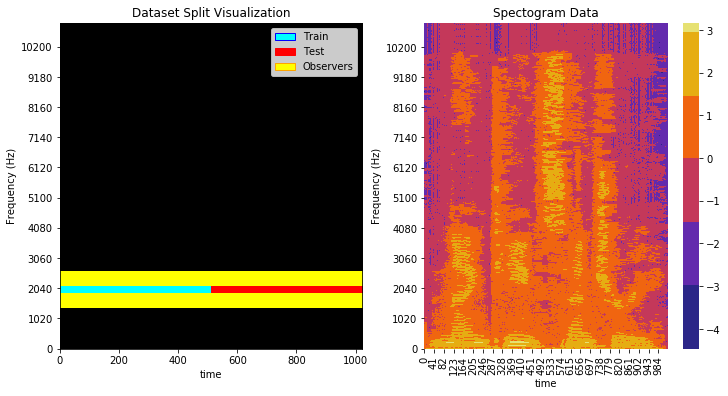

X target shape: (512, 100)
X test shape: (512, 100)
response train shape: (512, 24)
response test shape: (512, 24)
observer_range: [[841, 891], [915, 965]]
response range: [[891, 915]]
total observers: 100
total targets: 24


In [22]:
#TODO: split this dict up or eliminate it. Let's just have an observer dict.
complex_dict = {
    "small" : { 
        
        #target_frequencies
        "2k" : 101,
        "4k" : 206,
        "8k" : 307,
        
        #target spread sizes
        "no_spread" : None,
        "small_spread" : 4,
        "medium_spread" : 12,
        "large_spread" : 24,
        
        #observer values
        "small_obs" : 10,
        "medium_obs" : 25,
        "large_obs" : 50
    },
    "medium" : { 
        
        #target_frequencies
        "2k" : 101,
        "4k" : 206,
        "8k" : 307,
        
        #target spread sizes
        "no_spread" : None,
        "small_spread" : 4,
        "medium_spread" : 12,
        "large_spread" : 24,
        
        #observer values
        "small_obs" : 10,
        "medium_obs" : 25,
        "large_obs" : 50
    },
    
    "publish": {
        "2k" : 546,
        "4k" : 1089,
        "8k" : 2177,
        "0.5_sec" : 1371,
        "0.7_sec" : 1924
    }
}

# size: medium, 1k by 1k
obs = "large_obs"

n_obs = complex_dict[size][obs] #(on each side)
ctr = key_freq_idxs[2000]
target_freq_["spread"] = 12
if target_freq_["spread"] != None:
    target_frequency = [ctr - target_freq_["spread"], 
                        ctr + target_freq_["spread"]]#[height - 700, height - 450]
    tf = target_frequency
    resp_range_ = [[tf[0], tf[1]]]
else: 
    resp_range_ = None
    tf = [ctr, ctr]
obs_range_  = [[tf[0] - n_obs, tf[0]], [tf[1], tf[1] + n_obs ]]


dat = get_observers(method = "block",
                    missing = ctr,
                    split = 0.5,
                    dataset = A,
                    observer_range = obs_range_,  #format: [[425, 525], [527,627]],
                    response_range = resp_range_, #format: [[525, 527]],
                    aspect = 1)

Train, Test, xTr, xTe  = dat["obs_tr"], dat["obs_te"], dat["resp_tr"], dat["resp_te"]
print("total observers: " + str(len(dat["obs_idx"])))
print("total targets: " + str(len(dat["resp_idx"])))
# try to make an interactive result, where you can pull up any timeseries. R?

sanity check
Does the obs_tr match the what we expect?


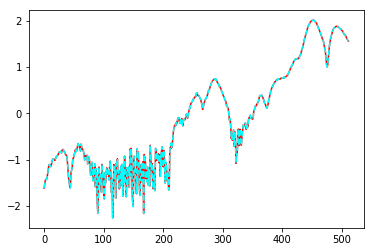

In [23]:
print("sanity check")
print("Does the obs_tr match the what we expect?")

orig_series, processed_series = A[0:dat["obs_tr"].shape[0], dat["obs_idx"][0]], dat["obs_tr"][:,0]

plt.plot(orig_series, color = "red")
plt.plot(processed_series, linestyle = "--", color = "cyan")
assert(np.array_equal(orig_series, processed_series))

# Data Saving Functions

In [24]:
from datetime import date
import pathlib

def count_files(path, current):
    count = 0
    for path in pathlib.Path(path).iterdir():
        if path.is_file():
            count += 1
    if current:
        count = count - 1
    return("_" + str(count))


def get_new_filename(exp, 
                     obs = len(dat["obs_idx"]), 
                     target_freq = "2k",
                     ctr = key_freq_idxs[2000],
                     spread = target_freq_["spread"],
                     current = False
                    ):
    """
    ideally this function will serve two purposes: it will return a new filename and return 
    a dict of data so that we can recreate the experiment. 
    This should include 
        1) The obs and resp indices, the "best_arguments" (the optimized hyper-parameters),
        and the prediction.
    """
    if exp:
        prefix = 'exp_w'
    else: 
        prefix = 'non_exp_w'
    obs, ctr, spread  = str(obs), str(ctr), str(spread)
    
    new_dir = "results/" + size + "/" + target_freq + "/"
    count = count_files(new_dir, current = current)
    new_filename =  prefix  + count + ".txt"
    return(new_dir +  new_filename )

def getData2Save(): #best_arguments, prediction = obs_prediction
    """
    Save the data
    current issue: how do we initialize this function properly?
    """
    err_msg = "YOU NEED TO CALL THIS FUNCTION LATER "
    json2be = {}
    
    
    
    # 1) saving the structure of the data and split
    json2be["basic_info"] = {"size" : size, 
                             "freq" : freq,
                        "target_freq_" : target_freq_, 
                        "n_obs" : len(dat["obs_idx"]),
                        "n_target" : len(dat["resp_idx"]),
                        "split_cutoff" : dat["resp_tr"].shape[0]}
    #jsonify dat
    new_dat = dat.copy().copy()
    for key, item in new_dat.items():
        if type(item) != list:
            new_dat[key] = item.tolist()
    
    json2be["dat"] = new_dat
    
    
    # 2) saving the optimized hyper-parameters
    try:
        best_arguments
    except NameError:
         err_msg + "RC not yet trained"
    else:
        json2be["best_arguments"] = best_arguments
    
    # 3) saving the prediction, mse
    try:
        obs_prediction
    except NameError:
         err_msg + "obs_prediction not yet created"
    else:
        json2be["prediction"] = obs_prediction.tolist()
        mse = my_MSE(obs_prediction, dat["resp_te"], verbose = False)
        json2be["results"] = {
            "MSE" :  mse,
            "RMSE" : np.sqrt(mse)
        }
    return(json2be)

def save_json(exp):
    save_spec_ = getData2Save()
    new_file = get_new_filename(exp = exp)
    with open(new_file, "w") as outfile:
        data = json.dump(save_spec_, outfile)
        
def my_MSE(prediction, truth, verbose = True, label = ""):
    mse_matrix = (prediction - truth)**2
    mse = np.sum(mse_matrix)/(mse_matrix.shape[0]*mse_matrix.shape[1])
    if verbose == True:
        print(label + " MSE: " + str(mse))
    return(mse)

# non exponential weights:

In [25]:
%%time
currTime()
run_now = False
if run_now == True:
    bounds = {
        #'llambda' : (-12, 1), 
        'connectivity': 0.5888436553555889, #(-3, 0)
        'n_nodes': (100, 1500),
        'spectral_radius': (0.05, 0.99),
        'regularization': (-12, 1),
    }
    esn_cv = EchoStateNetworkCV(bounds = bounds,
                                initial_samples=100,
                                subsequence_length=250, #150 for 500
                                eps=1e-5,
                                cv_samples=8, 
                                max_iterations=1000, 
                                scoring_method='tanh',
                                exp_weights = False,
                                obs_index = dat['obs_idx'],
                                target_index = dat["resp_idx"])
    
    # n_jobs is the number of computer cores.
    esn_cv.n_jobs = 5
    
    #Optimize the hyper-parameters
    best_arguments = esn_cv.optimize( x = Train, y = xTr) 
    
    # Save the Data
    save_json(exp = False)
    
""" 7/26, 2k, medium, spread 12, n_obs = 50, llambda is : 8.249737488807662e-05
best_arguments = {
    'connectivity': 0.5888436553555889,
    'n_nodes': 100,
    'spectral_radius': 0.05,
    'regularization': 0.00019661357203730104}
"""

Current Time = 17:00:47
CPU times: user 698 µs, sys: 652 µs, total: 1.35 ms
Wall time: 1.07 ms


" 7/26, 2k, medium, spread 12, n_obs = 50, llambda is : 8.249737488807662e-05\nbest_arguments = {\n    'connectivity': 0.5888436553555889,\n    'n_nodes': 100,\n    'spectral_radius': 0.05,\n    'regularization': 0.00019661357203730104}\n"

In [26]:
def load_best_args(exp, file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        non_exp_best_args = json.load(json_file)
    best_args = non_exp_best_args["best_arguments"]
    return(best_args)
def load_dat(exp, file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        non_exp_best_args = json.load(json_file)
    datt = non_exp_best_args["dat"]
    datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

In [27]:
non_exp_best_args

NameError: name 'non_exp_best_args' is not defined

In [51]:
print(A.shape)
print(xTe.shape[0] + xTr.shape[0])
range(A.shape[0] - xTe.shape[0], A.shape[0])

(1024, 1103)
1024


range(512, 1024)

In [111]:
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
def nrmse(pred_, truth):
    """
    inputs should be numpy arrays
    """
    rmse_ = np.sqrt(np.sum((truth - pred_) ** 2))
    denom_ = truth ** 2
    nrmse_ = rmse_ / denom_
    return(nrmse_)
    

def runInterpolation():
    #2D interpolation
    #observer coordinates
    
    """
    for i, column_idx in enumerate(dat["resp_idx"]):
            print(column_idx)
            values += list(A[:,column_idx].reshape(-1,))
            point_lst += list(zip(range(A.shape[0]), [column_idx]*A.shape[0]))
    print(len(point_lst))
    print(len(values))
    """
    
    #Training points
    missing_ = 60
    points_to_predict = []
    
    values = []
    #visible
    point_lst = []
    
    total_zone_idx = dat["resp_idx"] + dat["obs_idx"]
    #Train zone
    for x in range(xTr.shape[0]):
        # resonse points : train
        for y in total_zone_idx:
            point_lst += [(x,y)]#list(zip(range(Train.shape[0]) , [missing_]*Train.shape[0]))
            values    += [A[x,y]]
            
    #Test zone
    for x in range(A.shape[0] - xTe.shape[0], A.shape[0]):
        # resonse points : train
        for y in dat["resp_idx"]:
            points_to_predict += [(x,y)]#list(zip(range(Train.shape[0]) , [missing_]*Train.shape[0]))
            #values    += [A[x,y]]
            
        #observer points
        for y in dat["obs_idx"]:
            point_lst += [(x,y)]
            values    += [A[x,y]]
            
            
        #just iterate through dat_idx
    print("point list length: " + str(len(point_lst)))
    print(xTe.shape)
    print(xTe.shape[0] * xTe.shape[1])
    #observer points
    #values += list(A[:Train.shape[0], column_idx].reshape(-1,))
    
    #nnpoints_to_predict = list(zip(list(range(Train.shape[0], A.shape[0])), [missing_]*xTe.shape[0]))
    ip2_pred = griddata(point_lst, values, points_to_predict, method='cubic')
    ip2_pred = ip2_pred.reshape(xTe.shape)
    ip2_resid = ip2_pred - xTe
    #points we can see in the training set

    ###plots:
    ip_res = {"prediction": ip2_pred,  "resid" : ip2_resid, "nrmse" : nrmse(pred_ = ip2_pred, truth = xTe) }
    return(ip_res)


In [112]:
print(len(dat["resp_idx"]))
print(len(list(range(A.shape[0] - xTe.shape[0], A.shape[0]))))

24
512


In [113]:
ip_res = runInterpolation()

point list length: 114688
(512, 24)
12288


In [110]:
ip_res

loaded!


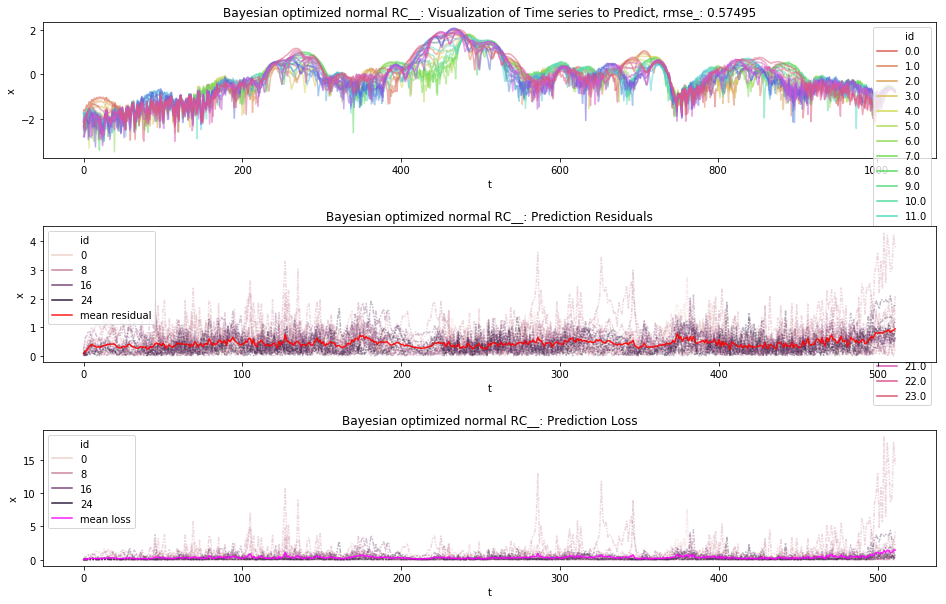

{'n_nodes': 1466,
 'spectral_radius': 0.9436655497550964,
 'regularization': 0.005634420389409391,
 'connectivity': [0.5888436553555889],
 'random_seed': 123}

None

In [44]:
#%run -i '/Users/hayden/Desktop/DL_LAB/Reservoir/build/lib/reservoir/esn.py'
#new_file = nf
#non_exp_best_args = best_arguments#load_best_args(exp = False)#, file ="results/small/2k/exp_w_7.txt")#, file = "results/_orig/non_exp_w_small_2k_100ctr_sig12.txt")
#dat = load_dat(exp = False, file = "results/small/2k/exp_w_2.txt")
#Train, Test, xTr, xTe  = dat["obs_tr"], dat["obs_te"], dat["resp_tr"], dat["resp_te"]
print("loaded!")


#non_exp_best_args['connectivity'] = [10**(-0.23)]
esn_obs = EchoStateNetwork(**non_exp_best_args,  exponential = False, 
                           resp_idx = dat["resp_idx"], obs_idx = dat['obs_idx'])
esn_obs.llambda = 10 ** (-2)
esn_obs.train(x = Train, y = xTr)

def my_predict(esn_spec, test, n_steps = None):
    if not n_steps:
        n_steps = test.shape[0]
    return esn_spec.predict(n_steps, x = Test[:n_steps,:])

obs_prediction = my_predict(esn_obs, Test)

col_to_plot = 3

hi = plot_timeseries(obs_prediction, 
                train = xTr, 
                test = xTe, 
                titl = "Bayesian optimized normal RC",
                method = "all",
                label_loc = (0.01, 0.7)) 


save_json(exp = False)
display(non_exp_best_args)
display(hi)

uniform MSE: 0.3305693228134346


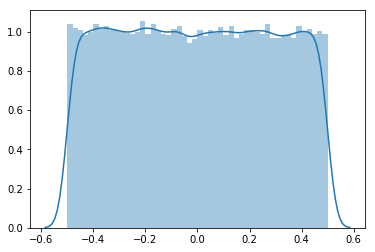

In [38]:

#sns.distplot(esn_obs.weights)
sns.distplot(esn_obs.in_weights)
    
non_exp_w_mse = my_MSE(obs_prediction, xTe, label = "uniform")

In [19]:
non_exp_best_args

{'n_nodes': 1466,
 'spectral_radius': 0.9436655497550964,
 'regularization': 0.005634420389409391,
 'connectivity': [0.5888436553555889],
 'random_seed': 123}

# non-expo model but expo weights

non_exp_mse_with_expo_weights MSE: 0.6046153258295529


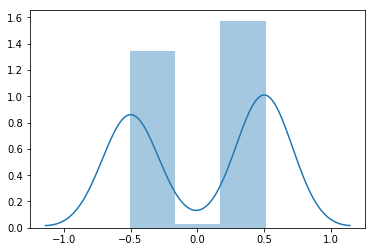

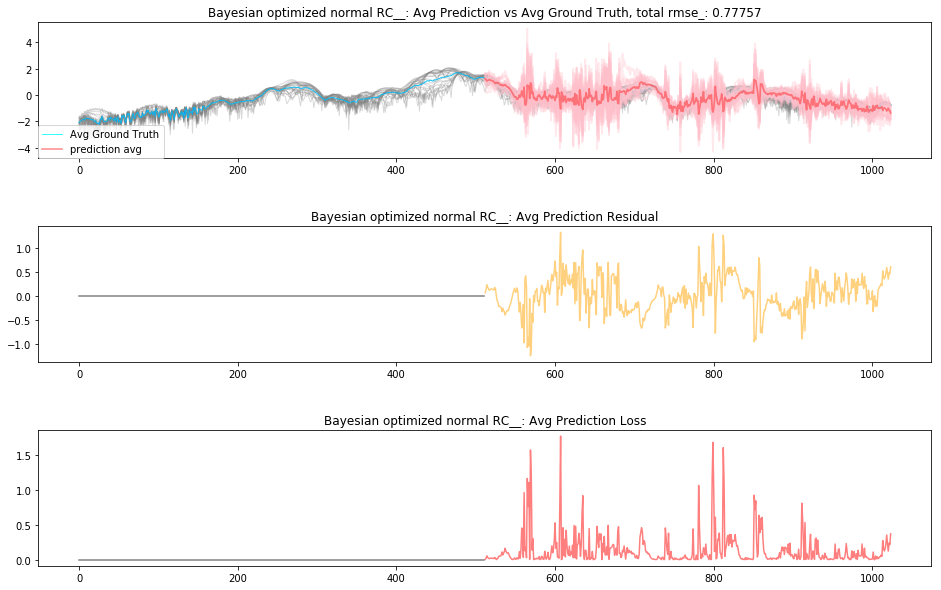

In [42]:

esn_obs = EchoStateNetwork(**non_exp_best_args,  exponential = True, 
                           resp_idx = dat["resp_idx"], obs_idx = dat['obs_idx'])
esn_obs.llambda =  0.00001
esn_obs.train(x = Train, y = xTr)
sns.distplot(esn_obs.in_weights)
def my_predict(esn_spec, test, n_steps = None):
    if not n_steps:
        n_steps = test.shape[0]
    return esn_spec.predict(n_steps, x = Test[:n_steps,:])

obs_prediction = my_predict(esn_obs, Test)

col_to_plot = 3
non_exp_w_mse_exp = my_MSE(obs_prediction, xTe, label = "non_exp_mse_with_expo_weights")
plot_timeseries(obs_prediction, method = "avg", train = xTr, test = xTe, titl = "Bayesian optimized normal RC", series2plot = 0) 

# exponential Weights Optimization

In [21]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

In [22]:
np.log(0.5888436553555889)/ np.log(10)

-0.23000000000000004

In [58]:
np.log(0.5888436553555889)/np.log(10)
np.log(0.005634420389409391)/np.log(10)

-2.24915075302124

In [ ]:
%%time
currTime()
"""'connectivity': 0.5888436553555889,
'n_nodes': 100,
'spectral_radius': 0.05,
'regularization': 0.00019661357203730104"""
run_now = True
if run_now == True:
    
    bounds = {'llambda': (-12, 1), 'n_nodes': 1466, 
         'spectral_radius': 0.9436655497550964, 
         'regularization': np.log(0.005634420389409391)/np.log(10), 
         'connectivity': np.log(0.5888436553555889)/np.log(10), 
         }
    for name, domain in bounds.items():
        
        if type(domain) == np.float64:
            print("hi")
            bounds[name] = float(bounds[name])
        print(type(domain))
    
    esn_cv = EchoStateNetworkCV(bounds = bounds,
                                initial_samples=100,
                                subsequence_length= 250,
                                eps=1e-5,
                                cv_samples=5, 
                                max_iterations=1000, 
                                scoring_method='tanh',
                                exp_weights = True,
                                obs_index = dat['obs_idx'],
                                target_index = dat["resp_idx"])
    ### n_jobs is the number of computer cores.
    esn_cv.n_jobs = 4
    esn_cv.n_jobs
    best_arguments = esn_cv.optimize( x = Train, y = xTr) 
    with open('exp_w.txt', "w") as outfile:
        data = json.dump(best_arguments, outfile)
"""
best_arguments = {
    'llambda': 8.249737488807662e-05,
    'connectivity': 0.5888436553555889,
    'n_nodes': 100,
    'spectral_radius': 0.05,
    'regularization': 0.00019661357203730104}
"""

Current Time = 11:33:43
<class 'tuple'>
<class 'int'>
<class 'float'>
hi
<class 'numpy.float64'>
hi
<class 'numpy.float64'>
Model initialization and exploration run...
Starting optimization... 

Hayden edit: space: <GPyOpt.core.task.space.Design_space object at 0x7f97120b7b10>
Hayden edit: fixed_parameters: ['n_nodes', 'spectral_radius', 'regularization', 'connectivity']
Hayden edit: free_parameters: ['llambda']
Score: 0.3962869577265196
Score: 0.39629902867880823
Score: 0.33134711215296375
Score: 0.39617154677087046
Score: 0.423903367555106
Score: 0.4669880748039329
Score: 0.43180781944836805
Score: 0.4107541936315157
Score: 0.3716313628981439
Score: 0.4494959907458097
Score: 0.442086464236894
Score: 0.44956785860650733
Score: 0.525134914630491
Score: 0.5257305502452043
Score: 0.5257063221999642
Score: 0.42380175812851567
Score: 0.4215778989108057
Score: 0.43077489799905455
Score: 0.430975390825903
Score: 0.4308194950703344
Score: 0.4340419144911518
Score: 0.4162366683285104
Score: 0.

In [50]:
exp_best_args

{'leaking_rate': 0.6758817434310913,
 'spectral_radius': 1.25,
 'regularization': 2.893725371567754,
 'connectivity': 0.001,
 'n_nodes': 136,
 'random_seed': 123}

In [49]:
#%run -i '/Users/hayden/Desktop/DL_LAB/Reservoir/build/lib/reservoir/esn.py'
exp_best_args = best_arguments
#exp_best_args = load_best_args(exp = True)
display(exp_best_args)

esn_obs = EchoStateNetwork(**exp_best_args, exponential = True, 
                           resp_idx = dat["resp_idx"], obs_idx = dat['obs_idx'], plot = True)
esn_obs.train(x = Train, y = xTr)

fig,ax = plt.subplots(1,1)
sns.distplot(esn_obs.in_weights, ax = ax)
ax.set_title("Exponential Attention weights Kernel Density")

def my_predict(test, n_steps = None):
    if not n_steps:
        n_steps = test.shape[0]
    return esn_obs.predict(n_steps, x = Test[:n_steps,:])

obs_prediction = my_predict(Test)


plot_timeseries(obs_prediction, method ="avg",
                train = xTr, test = xTe, titl = "Bayesian optimized RC", series2plot = 0) 


{'leaking_rate': 0.6758817434310913,
 'spectral_radius': 1.25,
 'regularization': 2.893725371567754,
 'connectivity': 0.001,
 'n_nodes': 136,
 'random_seed': 123}

TypeError: bad operand type for unary -: 'NoneType'

In [25]:

    
exp_w_mse = my_MSE(obs_prediction, xTe, label = "exp_w")

save_json(exp = True)

exp_w MSE: 0.28321888125854194


# Expo-opt but non-expo model

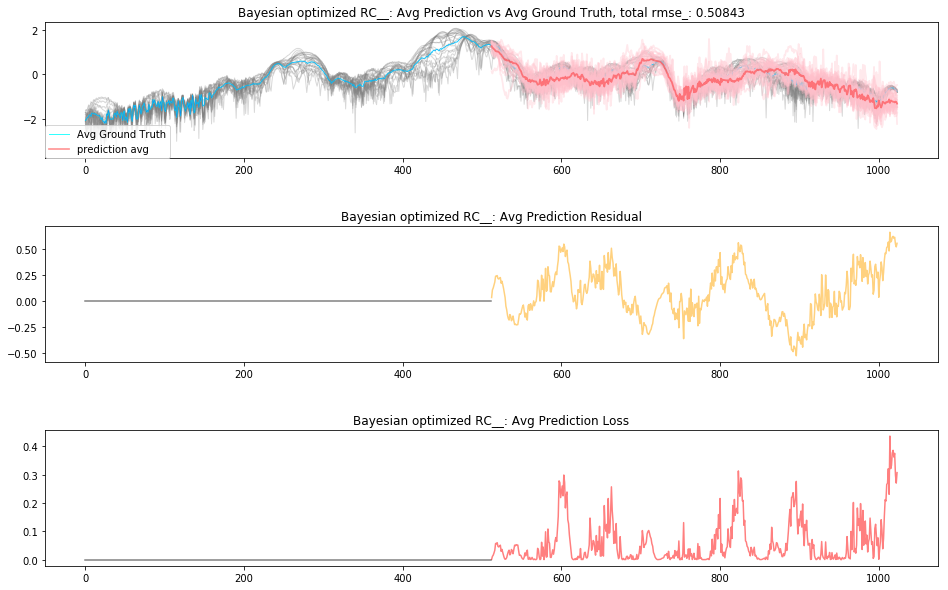

exp_w_non MSE: 0.2585055845060937


In [26]:
#%run -i '/Users/hayden/Desktop/DL_LAB/Reservoir/build/lib/reservoir/esn.py'


esn_obs = EchoStateNetwork(**exp_best_args, exponential = False, 
                           resp_idx = dat["resp_idx"], obs_idx = dat['obs_idx'], plot = True)

#esn_obs.llambda = np.exp(-)
esn_obs.train(x = Train, y = xTr)

def my_predict(test, n_steps = None):
    if not n_steps:
        n_steps = test.shape[0]
    return esn_obs.predict(n_steps, x = Test[:n_steps,:])

obs_prediction = my_predict(Test)


plot_timeseries(obs_prediction, train = xTr, test = xTe, titl = "Bayesian optimized RC", series2plot = 0,
               method = "avg") 
exp_w_mse_non = my_MSE(obs_prediction, xTe, label = "exp_w_non")

In [27]:
#best_arguments

(array([ 4.,  8.,  8., 13., 18., 18., 13.,  8.,  6.,  4.]),
 array([-0.01936876, -0.01521718, -0.0110656 , -0.00691402, -0.00276244,
         0.00138914,  0.00554072,  0.0096923 ,  0.01384388,  0.01799546,
         0.02214704]),
 <a list of 10 Patch objects>)

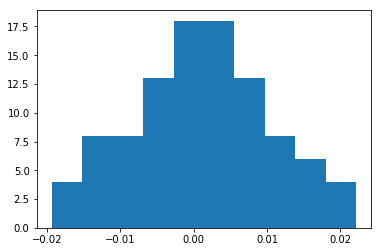

In [28]:
plt.hist(np.random.normal(size = 100)/100)

# Comparison / Improvement:

In [29]:
print("Inter-optimization:")
print("uniform weights MSE: " + str(non_exp_w_mse))
print("exponential weights MSE: " + str(exp_w_mse))
pct_improvement = round((non_exp_w_mse - exp_w_mse)*100 / non_exp_w_mse, 2)
print("Mse was reduced by " + str(pct_improvement) + "%")

Inter-optimization:
uniform weights MSE: 0.3305693228134346
exponential weights MSE: 0.28321888125854194
Mse was reduced by 14.32%


In [30]:
print("Intra-optimization:")
print("exp_w optimized:")
print("uniform weights MSE: " + str(exp_w_mse_non))
print("exponential weights MSE: " + str(exp_w_mse))
pct_improvement = round((non_exp_w_mse - exp_w_mse)*100 / non_exp_w_mse, 2)
print("Mse was reduced by " + str(pct_improvement) + "%")

Intra-optimization:
exp_w optimized:
uniform weights MSE: 0.2585055845060937
exponential weights MSE: 0.28321888125854194
Mse was reduced by 14.32%


In [31]:
print("Intra-optimization:")
print("non_exp_w optimized:")
print("uniform weights MSE: " + str(non_exp_w_mse))
print("exponential weights MSE: " + str(non_exp_w_mse_exp))
pct_improvement = round((non_exp_w_mse - non_exp_w_mse_exp)*100 / non_exp_w_mse, 2)
print("Mse was reduced by " + str(pct_improvement) + "%")

Intra-optimization:
non_exp_w optimized:
uniform weights MSE: 0.3305693228134346
exponential weights MSE: 0.5359608670660769
Mse was reduced by -62.13%


# Simple predictions

In [32]:
#TODO

# Now testing multiple outputs:

In [33]:
%%time

#dat = get_observers("all")
#plt.plot(xTr)
Train  = dat["obs_tr"]
Test   = dat["obs_te"]
xTr    = dat["resp_tr"]
xTe    = dat["resp_te"]

CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 8.11 µs


Model initialization and exploration run...
Starting optimization... 

Hayden edit: space: <GPyOpt.core.task.space.Design_space object at 0x7f96f0f02890>
Hayden edit: fixed_parameters: []
Hayden edit: free_parameters: ['leaking_rate', 'spectral_radius', 'regularization', 'connectivity', 'n_nodes']
Score: 0.9958620250897086
Score: 0.9934218447595915
Score: 0.9983215515275449
Score: 0.989194662728764
Score: 0.9867948505895414
Score: 0.14097998187676014
Score: 0.7669076550170395
Score: 0.9815018141937379
Score: 0.9953920873350298
Score: 0.9732897529792406
Score: 0.9955399034779818
Score: 0.9999637202362409
Score: 0.9998335234175332
Score: 0.2508370502904847
Score: 0.9999876697671907
Score: 0.36838455780893004
Score: 0.17168287548278904
Score: 0.40288842398336133
Score: 0.35930605101800916
Score: 0.2617199153476336
Score: 0.1410686218937835
Score: 0.9986183592117032
Score: 0.982817004024754
Score: 0.9999985245012206
Score: 0.9873913416240124
Score: 0.9990458022528494
Score: 0.9999916946000

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Model initialization done. 


Name : GP regression
Objective : 100.47630136056475
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |       priors      
  Mat52.variance           |    0.652301670749027  |      +ve      |  iGa(0.001, 0.001)
  Mat52.lengthscale        |                 (5,)  |      +ve      |  iGa(0.001, 0.001)
  Gaussian_noise.variance  |  0.07573396406335502  |      +ve      |  iGa(0.001, 0.001) 

  index  |  GP_regression.Mat52.lengthscale  |  constraints  |       priors      
  [0]    |                       2.39528300  |      +ve      |  iGa(0.001, 0.001)
  [1]    |                       7.19902989  |      +ve      |  iGa(0.001, 0.001)
  [2]    |                       0.13760522  |      +ve      |  iGa(0.001, 0.001)
  [3]    |                       2.04185616  |      +ve      |  iGa(0.001, 0.001)
  [4]    |                       5.19727724  |      +ve      |  

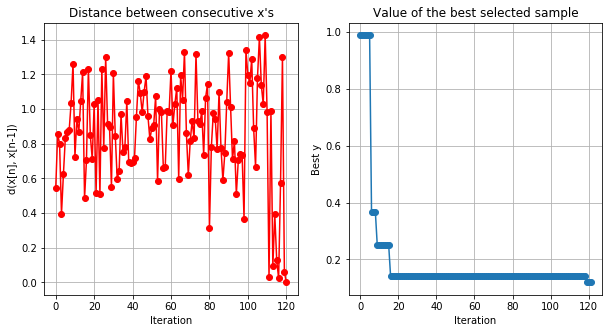

CPU times: user 1min 18s, sys: 13.2 s, total: 1min 32s
Wall time: 16min 59s


In [34]:
%%time

bounds = {
    #'input_scaling': (0, 1),
    #'feedback_scaling': (0, 1),
    'leaking_rate' : (0, 1), 
    'spectral_radius': (0.01, 1.25),
    'regularization': (-12, 1),
    'connectivity': (-3, 0),
    'n_nodes':  (100, 1000)
}
esn_cv = EchoStateNetworkCV(bounds=bounds,
                            initial_samples=100,
                            subsequence_length=250,
                            eps=1e-4,
                            cv_samples=3, 
                            max_iterations=1000, 
                            scoring_method='tanh',
                            verbose=True)

### n_jobs is the number of computer cores.
esn_cv.n_jobs = 8
esn_cv.n_jobs
best_arguments = esn_cv.optimize(x = Train, y = xTr) 

In [35]:
esn_obs = EchoStateNetwork(**best_arguments)
esn_obs.train(x = Train, y = xTr)
BO_obs_prediction = my_predict(Test)
#plot_timeseries(prediction, train = xTrTarg, test = xTeTarg )

plot_timeseries(BO_obs_prediction, train = xTr, test = xTe, titl = "Bayes", col2plot = 0)
plot_timeseries(BO_obs_prediction, train = xTr, test = xTe, titl = "Bayes", col2plot = 40)


TypeError: plot_timeseries() got an unexpected keyword argument 'col2plot'

In [ ]:
kk = 20

fig, ax = plt.subplots(1,1,figsize = (16,4))
orig_idx = list(range(0,len(xTe[:,0])-1, kk))
resids_y_vals = []
resids_x_vals = []
count = 0
x_range= np.array(list(range(len(xTe[:,1])-1)))
print(x_range)
for i in range(0,100):
    count+=1
    resid_i = np.abs(xTe[:,i] - BO_obs_prediction[:,i])[orig_idx]
    resids_y_vals += resid_i.tolist()
    print(resid_i)
    break
    resids_x_vals += list(range(len(x_range[orig_idx].tolist())))
    plt.plot( resid_i, alpha = 0.05, color = "blue")
    
my_dict = {"x":resids_x_vals, "y":resids_y_vals}  
my_np = pd.DataFrame(my_dict).values


sorted_array = pd.DataFrame(my_np[np.argsort(my_np[:, 0])])

sorted_array.columns = ["x", "y"]

display(sorted_array)
    
sns.regplot( x = "x", y = "y",data = sorted_array, color = "red",  x_jitter=.1) #alpha = 0.1)
ax.set_title = "Absolute Residual: all 180 Timeseries"

#clean this up by making the reg-plot work via a dataframe. But since this is extra I'm moving on.

In [ ]:
xTe.shape

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,4))
for i in range(len(dat["resp_idx"])):
    resid_i = (xTe[:,i]-BO_obs_prediction[:,i])**2
    plt.scatter(x = range(len(resid_i)), y = resid_i, alpha = 0.1, c= resid_i)
ax.set_title = "Absolute Residual: all 180 Timeseries"

In [ ]:
loss_np = np.zeros([xTe.shape[0], xTr.shape[1]])
total_np = np.zeros([pred_.shape[0], pred_.shape[1]])
fig, ax = plt.subplots(1,1,figsize = (16,4))
for count, i in enumerate(range(len(dat["resp_idx"]))):
    resid_i = abs(xTe[:,i] - BO_obs_prediction[:,i])#**2
    loss_np[:,i] = resid_i
    
    plt.plot( resid_i, alpha = 0.04, color = "blue")
for count, i in enumerate(range(len(dat["resp_idx"]))):
    resid_i = (xTe[:,i] - BO_obs_prediction[:,i])**2
    #print(resid_i.shape)
    
ax.set_title = "Absolute Residual: all 180 Timeseries"

In [ ]:
#let's get the original data


def other_lab(arr):
    return(np.rot90(arr, k=1, axes=(0, 1)))

fig, ax = plt.subplots(1,3, figsize=[15,10])
ax = ax.flatten()
#plt.imshow(loss_np)
sns.heatmap(other_lab(loss_np), ax = ax[0])
ax[0].set_title("residual error")

ax[1].set_title("prediction")
sns.heatmap(other_lab(BO_obs_prediction), ax = ax[1], cmap = "CMRmap")

ax[2].set_title("original")
sns.heatmap(other_lab(xTe), ax = ax[2], cmap = "CMRmap")
plt.subplots_adjust(hspace = 0.5)

In [ ]:
orig_idx = list(range(0, 420, 20))

#reverse interpolation function
def non_ip(arr):
    return(arr[orig_idx,:])


fig, ax = plt.subplots(1,3, figsize=[15,10])
ax = ax.flatten()

ax[0].set_title("original")
sns.heatmap(other_lab(non_ip(xTe)), ax = ax[0], cmap = "CMRmap")
ax[0].set_xlabel("time")

ax[1].set_title("prediction")
sns.heatmap(other_lab(non_ip(BO_obs_prediction)), ax = ax[1], cmap = "CMRmap")
ax[1].set_xlabel("time")

sns.heatmap(other_lab(non_ip(loss_np)), ax = ax[2])
ax[2].set_title("residual error")
ax[2].set_xlabel("time")

# Deleted Scenes:

exp_weights

In [ ]:
def exp_w(llambda = 1, distance = None, verbose = False):
        """
        Args:
            llambda: is llambda in an exponential function.
            distance: is a distance matrix. 
        
        This function calculates weights via attention ie the
        distance matrix which measures the distance from the 
        observer sequences to the target sequences.
        """
        exp_np = np.exp( - llambda * distance) #*llambda
        exp_np = exp_np.sum(axis = 0).reshape( -1 )
        
        #normalize the max weight to 1.
        exp_np = (exp_np) / np.max(exp_np)
        
        if(verbose) == True:
            display(pd.DataFrame(exp_np))
            print("sum = " + str(np.sum(exp_np)))
        
        return(exp_np)
        
def build_distance_matrix(resp, obs, verbose = False):
    """
    args:
        resp is the response index (a list of integers associated with the target train/test time series 
            (for example individual frequencies)
        obs is the same for the observation time-series.
    Description:
        DistsToTarg stands for distance numpy array
    """
    for i, resp_seq in enumerate(resp):
        DistsToTarg = abs(resp_seq - np.array(obs)).reshape(1,-1)
        if i == 0:
            distance_np = DistsToTarg
        else:
            distance_np = np.concatenate([distance_np, DistsToTarg], axis = 0)
    if verbose == True:
        display(pd.DataFrame(distance_np))
    return(distance_np)



def get_exp_weights(resp_idx = dat["resp_idx"], 
                    obs_idx = dat["obs_idx"],
                    plot = True): #change the automatic var assignments
    d_mat = build_distance_matrix(resp_idx, obs_idx)
    exp_weights = exp_w(llambda = 0.05, distance = d_mat)
    n_temp = len(exp_weights)
    sign = np.random.choice([-1,1],n_temp)
    #print("exp weights shape", exp_weights.shape)

    exp_weights *= sign

    pd_ = pd.DataFrame({"obs_idx": obs_idx, "weight": exp_weights})
    #print("max_weight: " + str(np.max(exp_weights)))
    if plot == True:
        fig, ax = plt.subplots(1,1, figsize = (6, 4))
        sns.scatterplot(x = "obs_idx", y = "weight", data = pd_, ax = ax)
        ax.set_title("Exponential Attention Weights")
    return(exp_weights)
    
get_exp_weights()



Visualization

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (16,4))
for i in range(A.shape[0]):
    ax.plot( A[:,i], alpha =  0.01)
ax.set_xlabel("Time")
ax.set_ylabel("Normalized Intensity")

Expand

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

def set_Diff(set_a, set_b):
    
    if type(set_a) == range:
        set_a = list(set_a)
    if type(set_b) == range:
        set_b = list(set_b)
    
    if type(set_a) == list:
        set_a = set(set_a)
    if type(set_b) == list:
        set_b = set(set_b)
        
    c = set_a.intersection(set_b)
    
    set_diff = set_a.union(set_b)-c
    return(list(set_diff))


def get_all_coords(shape_):
    """
    args: shape: the shape of the numpy array you want all the cartesian points for.
    """
    pnt_lst = []
    range0 = range(shape_[0])
    range1 = range(shape_[1])
    for x_coord in range0:
        pnt_lst += list(zip([x_coord]*len(range1), range1))
    return(pnt_lst)

    

def expand(arr, k = 6, axis = 0):
    """
    args:
        k: the number of points (padding) between points
        arr: the numpy array that we're trying to expand via interpolation
        axis: 0 is row-wise, 1 is column wise.
    """
    other_axis = (axis +1) % 2
    
    known_pnt_lst   = []
    known_values    = []
    
    unknown_pnt_lst = []
    
    x_coords = range(0, arr.shape[axis]*k, k)
    
    full_lst = list(range(arr.shape[axis]*k))

    unknown_x_coords = set_Diff(x_coords, full_lst)    
    #all coords
    
    for i in range(A.shape[1]):
        
        known_pnt_lst   += list(zip(x_coords, [i]*A.shape[1]))
        known_values    += list(A[:,i].reshape(-1,))
        
        unknown_pnt_lst += list(zip(unknown_x_coords, [i] * A.shape[1]))

    #pnts_to_ip is points to interpolate
    #return({"act_pnts" : known_pnt_lst, "pnts_to_ip" : known_pnt_lst})
    
    
    #verbatim:
    #for i, column_idx in enumerate(dat["tr_idx"]):
    #        print(column_idx)
    #        values += list(A[:,column_idx].reshape(-1,))
    #        point_lst += list(zip(range(A.shape[0]), [column_idx]*A.shape[0]))
    #print(len(point_lst))
    #print(len(values))
    
    #Next in this function:
    point_lst = known_pnt_lst
    points_to_predict = get_all_coords((A.shape[0]*k, A.shape[1]))#unknown_pnt_lst
    ip2_pred = griddata(point_lst, known_values, points_to_predict, method='cubic')
    ip2_pred = ip2_pred.reshape(-1, A.shape[1])
    return({"prediction" : ip2_pred, "non_ip_idx": x_coords })

71*(706)

In [ ]:
def how_many_less_than(threshold= 0.1):
    """
    This function tells home many are in np array are less than a a value.
    """
    threshold = 0.1
    pct_less = int(100 * np.sum(exp_weights < threshold)/len(exp_weights))
    print("pct of exp_weights less than " + str(threshold)+ ": " + str(pct_less)+"%")

In [ ]:
### # ii. Hackily change directory and then run esn_cv.py 

#import os
#reservoir_package_dir = '/Users/hayden/Desktop/DL_LAB/Reservoir/reservoir'

#os.chdir(reservoir_package_dir)

#%run -i './esn_cv.py'
#/Users/hayden/Desktop/DL_LAB/Reservoir/reservoir

prediction = expand(A, k = 20)
res = prediction
pred_, non_ip_idx = res["prediction"], res["non_ip_idx"]

fig, ax = plt.subplots(1,2, figsize = (16,6))
ax = ax.flatten()

sns.heatmap(np.rot90(pred_, k=1, axes=(0, 1)),  center=0, cmap=sns.color_palette("CMRmap"), ax = ax[0])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('time')
ax[0].set_title("expanded spectogram (via interpolation)")
#
sns.heatmap(np.rot90(A, k=1, axes=(0, 1)),  center=0, cmap=sns.color_palette("CMRmap"), ax = ax[1])#, cmap = sns.color_palette("RdBu_r", 7))
#, cmap = sns.color_palette("RdBu_r", 7))
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('time')
ax[1].set_title("Original spectogram")
plt.show()

# Boundaries discussed with Zhizhuo

In [ ]:
"""
Block:
1371 = 0.5 sec,  1924 = 0.7 sec, 1.1 end

2k = 520-570 missing 50, 100 lines missing 500 - 600
        # observers: 50% of missing


Three window sizes 0.5->0.7, 0.5 -> 0.9, 0.5 -> 1.1

"""
window_end1, window_end2, window_end3 = 1371, 1924, "end"
#missing/response range
missing_range_50 = range(520,571)
missing_range_100 = range(500, 600)
display(missing_range)
width_half = 25
obs1_start_lhs, obs1_stop_lhs = range(520-width_half,520), range(571, 571 + width_half)
width_half = 50
obs1_start_lhs, obs1_stop_lhs = range(520-width_half,520), range(571, 571+width_half)

# Example of randomly selected obs below

In [ ]:
dat = get_observers("block",
                    num_observers = 40,
                    missing = 150,
                    split = 0.0,
                    dataset = A,
                    #observer_range = [[100,225], [275,400]],
                    #response_range = [[225,275]],
                    #Marios's request:
                    #observer_range = [[100,200], [300,400]],
                    response_range = [[2000,2002]],
                    aspect = 1)

In [ ]:
#unknown function:


# if this is set to 0 the reservoir package will be reinstalled 
#assuming it is sitting in a parent directory.
### YOU NEED TO RESTART THE NOTEBOOK after doing this, it also must be stopped manually.

    #%run -i "../reinstall.sh"
    #! pip uninstall --yes reservoir
    #! yes | pip install ../Reservoir/

# old version of plot_timeseries

In [ ]:
def plot_timeseries(prediction_, train, test, titl = "ESN ", series2plot = 0, method = None):
    """
    This function makes three plots:
        the prediction, the residual, the loss.
    It was built for single predictions, but needs to be upgraded to deal with multiple output.
    We need to show: average residual, average loss.
    """
    assert method != None, "Please choose a method: avg or single"
    
    if method == "single":
        
        # avoid choosing all of the columns. subset by the selected time series.
        train, test, prediction = train[:, series2plot], test[:, series2plot], prediction_[:, series2plot]
        #key indexes
        trainlen, testlen, pred_shape = len(train), len(test), len(prediction)
        
        # set up dataframe
        xTrTarg_pd = pd.DataFrame(test)
        t = pd.DataFrame(list(range(len(xTrTarg_pd))))
        
        # append time
        Target_pd = pd.concat([xTrTarg_pd, t], axis = 1)
        Target_pd.columns = ["x", "t"]
        
        #calculate the residual
        resid = test.reshape(-1,)[:pred_shape] - prediction.reshape(-1,) #pred_shape[0]
        
    
    rmse_spec =  str(round(myMSE(prediction, test), 5))
    
    full_dat = np.concatenate([train, test], axis = 0)
    
    #display(Target_pd)
    fig, ax = plt.subplots(3,1, figsize=(16,10))
    
    #The first plot
    #sns.lineplot(x = "t", y = "x", data = Target_pd, color = "black", ax = ax[0])
    ax[0].plot(range(full_dat.shape[0]), full_dat,'k', label="Ground Truth",
              color = "blue", linewidth = 3, alpha = 0.4)
    ax[0].plot(range(trainlen,trainlen+testlen),prediction,'k',
             label="prediction", color = "r", linestyle = "--", linewidth = 2, alpha = .95)
    #first plot labels
    ax[0].set_title(titl + "__: Prediction vs Ground Truth, rmse_: " + rmse_spec)
    ax[0].legend(loc=(0.31, 1.1))#(0.61, 1.1))
    
    # the second plot
    ax[1].plot(range(0,trainlen),np.zeros(trainlen),'k',
             label="", color = "black", alpha = 0.5)
    ax[1].plot(range(trainlen,trainlen+testlen),resid.reshape(-1,),'k',
             color = "purple", alpha = 0.5)
    # second plot labels
    #ax[1].legend(loc=(0.61, 1.1))
    ax[1].set_title(titl + "__: Prediction Residual")
    
    
    # the second plot
    ax[2].plot(range(0,trainlen),np.zeros(trainlen),'k',
             label="", color = "black", alpha = 0.5)
    ax[2].plot(range(trainlen,trainlen+testlen),resid.reshape(-1,)**2,'k',
             color = "r", alpha = 0.5)
    # second plot labels
    #ax[2].legend(loc=(0.61, 1.1))
    ax[2].set_title(titl + "__: Prediction Loss")
    
    plt.subplots_adjust(hspace=0.5)
    plt.show()